In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data
y = iris.target # [0=setosa, 1=versicolor, 2=virginica]
features = iris.feature_names

df = pd.DataFrame(X, columns=features)

## LDA

In [2]:
# create dict with classes
flowers = {
    'setosa': df[y==0],
    'versicolor': df[y==1],
    'virginica': df[y==2]
}

flowers_keys = list(flowers.keys())

# covariance matrix of each class
flowers_cov = dict()
for flower in flowers_keys:
    flowers_cov[flower] = pd.DataFrame.cov(flowers[flower])[:].values
    
# sw and sw inverse
sw = pd.DataFrame([[float(0) for a in range(4)] for b in range(4)])[:].values

for i in range(4):
    for j in range(4):
        sw[i][j] = flowers_cov['setosa'][i][j] + flowers_cov['versicolor'][i][j] + flowers_cov['virginica'][i][j]

swi = np.linalg.inv(sw)

# sb
sb = pd.DataFrame.cov(df)[:].values

# sw_inverse * sb
swi_sb = pd.DataFrame([[float(0) for a in range(4)] for b in range(4)])[:].values

for i in range(4):
    for j in range(4):   
        swi_sb[i][j] = swi[i][j] * sb[i][j]
        
# eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(swi_sb)

# transform in 2 dimensions
w = eigenvectors[:,[0,1]]
lda_X = X.dot(w)

## PCA

In [3]:
# transform lda_x to df
df_lda_X = pd.DataFrame({'x': lda_X[:, 0], 'y': lda_X[:, 1]})

# matrix mean
new_line = list()
new_matrix = list()

for col in df_lda_X.columns:
    average = df_lda_X[col].mean()
    
    for line in df_lda_X[col]:
        new_line.append(line - average)
        
    new_matrix.append(new_line)
    new_line = []

df_mean = pd.DataFrame(
    {
        'x': new_matrix[0], 
        'y': new_matrix[1]
    }
)

# covariance matrix
cov_m = pd.DataFrame.cov(df_mean)

# eigenvalues and eigenvectors of covariance marix
eigenvalues, eigenvectors = np.linalg.eig(cov_m)

# choosing principal component
sum_ = 0
sig_ = 0
index_ = -1

for col in range(eigenvectors.shape[1]):
    for row in range(eigenvectors.shape[0]):
        sum_ += eigenvectors[row][col]
        
    if sum_ <= sig_:
        index_ = col
        sig_ = sum_
        
sig_ = []

for row in range(eigenvectors.shape[0]):
    sig_.append(eigenvectors[row][index_])
    
df_sig = pd.DataFrame(sig_).values

# pca
rows = df_sig.T.shape[0]
cols = df_mean.T.shape[1]

pca = [[0 for a in range(cols)] for b in range(rows)]

for i in range(rows):
    for j in range(cols):
        result = 0
        for k in range(df_mean.T.shape[0]):
            result += df_sig.T[i][k] * df_mean.T[j][k]
        pca[i][j] = result

pca = pd.DataFrame(pca).values

# get average from each feature
vx = list()
features_ = ['x', 'y']

for f in features_:
    vx.append(df_mean[f].mean())


# add col in dataframe y = [0=setosa, 1=versicolor, 2=virginica]
df_mean['class'] = y
vy = df_mean['class'].mean()

vxy = list()
for k in vx:
    vxy.append(vx)
    
df_coords = pd.DataFrame(vxy).values

# principal component straight equation
m = (df_sig[1][0] - df_coords[1][0])/(df_sig[0][0] - df_coords[0][0])
b = (df_sig[0][0] * df_coords[1][0] - df_coords[0][0] * df_sig[1][0])/(df_sig[0][0] - df_coords[0][0])
y2 = []

for k in range(pca.T.shape[0]):
    y2.append(m * pca.T[k][0] + b)
    
# add data in dataframe
df_mean['x1'] = pca.T
df_mean['y1'] = y2

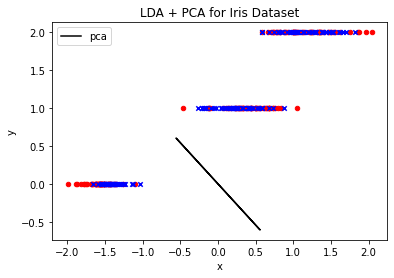

In [4]:
# plot graph
plot_df_mean = df_mean.plot.scatter(
    x='x', 
    y='class', 
    c='red', 
    marker='o',
)

df_mean.plot.scatter(
    x='y',
    y='class', 
    c='blue', 
    marker='x',
    ax=plot_df_mean,
)

df_mean.plot.line(
    x='x1',
    y='y1',
    c='black',
    ax = plot_df_mean,
    label='pca'
)
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('LDA + PCA for Iris Dataset')
plt.legend()